## Import all the packages 

In [1]:
from collections import defaultdict
import os, glob, random, sys, time, keras, cv2, itertools, sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils.fixes import signature
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
from keras.models import *
from keras.layers import *
from skimage import io
from sklearn.model_selection import train_test_split

C:\Users\kamru\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load all the images

In [2]:
CurrentDir=os.getcwd()
Dataset = os.listdir(CurrentDir+'/yalefacesData/')

Images = []
ImageLabel = []

for file in Dataset:
    if file!='Readme.txt':
        fileRead=CurrentDir+'/yalefacesData/'+file 
        imgRead = io.imread(fileRead, as_grey=True)
        Images.append(imgRead) 
        FileName = os.path.split(file)[1].split(".")[0]
        labelRead = int(FileName.replace("subject", "")) - 1 
        ImageLabel.append(labelRead)
        
print(len(Images))
print(Images[0].shape)
print(Images[0].dtype)

print(len(ImageLabel))
print(ImageLabel)


# Save the images in Test folder directory 
for i in range(len(Images)):
    image=Images[i]
    number='%03d'%i
    path=CurrentDir+'/test/'+str(number)+'.png'
    cv2.imwrite(path,image)

166
(243, 320)
uint8
166
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]


In [3]:
faceDetectClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [4]:
imageDataFin = []
for i in Images:
    facePoints = faceDetectClassifier.detectMultiScale(i)
#     print(facePoints[0])
    x,y = facePoints[0][:2]
    patch = i[y: y + 150, x: x + 150] # Taking the patch of 150x150
    imageDataFin.append(patch)
    
imageDataFin[0].shape

(150, 150)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(imageDataFin),
                                                    np.array(ImageLabel), 
                                                    train_size=0.9, 
                                                    random_state = 20)

C:\Users\kamru\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
X_train = np.array(X_train)
X_test = np.array(X_test)
print(X_train.shape)
print(X_test.shape)
nb_classes = 15
y_train = np.array(y_train) 
y_test = np.array(y_test)
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

(149, 150, 150)
(17, 150, 150)


In [7]:
X_train = X_train.reshape(149, 150*150)
X_test = X_test.reshape(17, 150*150)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (149, 22500)
Testing matrix shape (17, 22500)


In [8]:
model = Sequential()
model.add(Dense(512,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               11520512  
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                7695      
__________

In [9]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [10]:
modelName='ModelSaved'
SaveweightName= modelName+'.hdf5'
SaveModelName=modelName+'.yaml'

savedModel = ModelCheckpoint(SaveweightName,
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

model_yaml = model.to_yaml()
with open(SaveModelName, "w") as yaml_file:
    yaml_file.write(model_yaml)

In [11]:
history=model.fit(X_train, Y_train,
                  batch_size=64, 
                  nb_epoch=100, 
                  verbose=1, 
                  validation_data=(X_test, Y_test),
                  callbacks= [savedModel])

C:\Users\kamru\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 149 samples, validate on 17 samples
Epoch 1/100
149/149 [==============================] - 5s 31ms/step - loss: 4.5593 - acc: 0.1208 - val_loss: 11.4331 - val_acc: 0.1176

Epoch 00001: val_acc improved from -inf to 0.11765, saving model to ModelSaved.hdf5
Epoch 2/100
149/149 [==============================] - 0s 431us/step - loss: 11.8483 - acc: 0.1074 - val_loss: 5.6150 - val_acc: 0.2941

Epoch 00002: val_acc improved from 0.11765 to 0.29412, saving model to ModelSaved.hdf5
Epoch 3/100
149/149 [==============================] - 0s 441us/step - loss: 10.2222 - acc: 0.1477 - val_loss: 8.0328 - val_acc: 0.1765

Epoch 00003: val_acc did not improve from 0.29412
Epoch 4/100
149/149 [==============================] - 0s 434us/step - loss: 8.7231 - acc: 0.2416 - val_loss: 4.0770 - val_acc: 0.3529

Epoch 00004: val_acc improved from 0.29412 to 0.35294, saving model to ModelSaved.hdf5
Epoch 5/100
149/149 [==============================] - 0s 444us/step - loss: 6.4790 - acc: 0.3356 - v


Epoch 00042: val_acc did not improve from 0.94118
Epoch 43/100
149/149 [==============================] - 0s 424us/step - loss: 0.0320 - acc: 0.9933 - val_loss: 0.4669 - val_acc: 0.9412

Epoch 00043: val_acc did not improve from 0.94118
Epoch 44/100
149/149 [==============================] - 0s 427us/step - loss: 0.0377 - acc: 0.9933 - val_loss: 0.6665 - val_acc: 0.7059

Epoch 00044: val_acc did not improve from 0.94118
Epoch 45/100
149/149 [==============================] - 0s 437us/step - loss: 0.0478 - acc: 0.9933 - val_loss: 0.5709 - val_acc: 0.8235

Epoch 00045: val_acc did not improve from 0.94118
Epoch 46/100
149/149 [==============================] - 0s 417us/step - loss: 0.0479 - acc: 0.9933 - val_loss: 0.4047 - val_acc: 0.8824

Epoch 00046: val_acc did not improve from 0.94118
Epoch 47/100
149/149 [==============================] - 0s 424us/step - loss: 0.0628 - acc: 0.9799 - val_loss: 0.3798 - val_acc: 0.8824

Epoch 00047: val_acc did not improve from 0.94118
Epoch 48/100
1


Epoch 00086: val_acc did not improve from 0.94118
Epoch 87/100
149/149 [==============================] - 0s 424us/step - loss: 0.0236 - acc: 0.9866 - val_loss: 0.3250 - val_acc: 0.9412

Epoch 00087: val_acc did not improve from 0.94118
Epoch 88/100
149/149 [==============================] - 0s 434us/step - loss: 0.1037 - acc: 0.9732 - val_loss: 0.2789 - val_acc: 0.8824

Epoch 00088: val_acc did not improve from 0.94118
Epoch 89/100
149/149 [==============================] - 0s 431us/step - loss: 0.0302 - acc: 0.9933 - val_loss: 0.5753 - val_acc: 0.7059

Epoch 00089: val_acc did not improve from 0.94118
Epoch 90/100
149/149 [==============================] - 0s 434us/step - loss: 0.0681 - acc: 0.9732 - val_loss: 0.4486 - val_acc: 0.8824

Epoch 00090: val_acc did not improve from 0.94118
Epoch 91/100
149/149 [==============================] - 0s 441us/step - loss: 0.0440 - acc: 0.9866 - val_loss: 0.3112 - val_acc: 0.8824

Epoch 00091: val_acc did not improve from 0.94118
Epoch 92/100
1

C:\Users\kamru\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


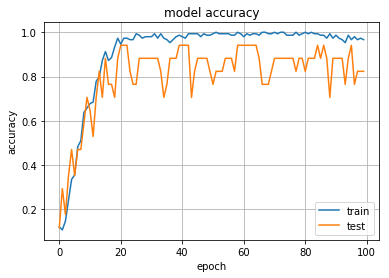

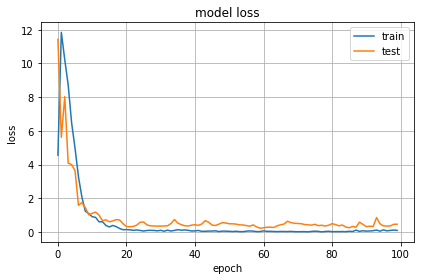

In [12]:
# plotting the metrics
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid('on')
plt.legend(['train', 'test'], loc='lower right')

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.grid('on')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

In [13]:
model.load_weights(SaveweightName)
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

17/17 [==============================] - 0s 177us/step
Test loss: 0.3190506100654602
Test accuracy: 0.9411764740943909


In [14]:
predicted_classes = model.predict_classes(X_test,verbose=1)
correct_classified_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_classified_indices = np.nonzero(predicted_classes != y_test)[0]
print(correct_classified_indices)
print(incorrect_classified_indices)

17/17 [==============================] - 0s 2ms/step
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16]
[14]


In [15]:
PRlabel=[]
for i in range(len(X_test)):
    X=X_test[i,:]
    X=X.reshape(1,22500)
#     print(X.shape)
    predictLabel=model.predict(X)
    PRlabel.append(np.argmax(predictLabel, axis=1))

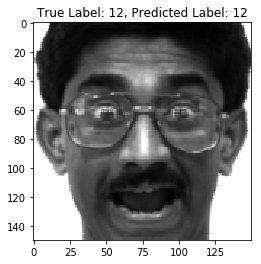

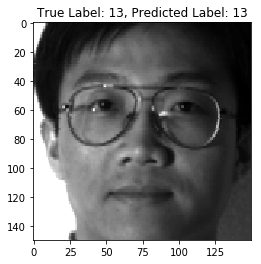

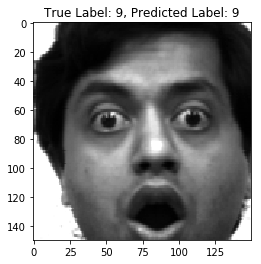

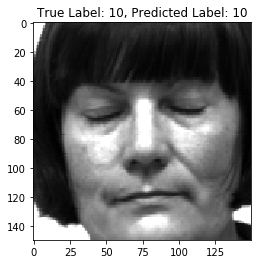

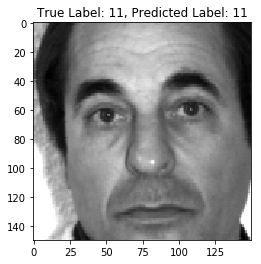

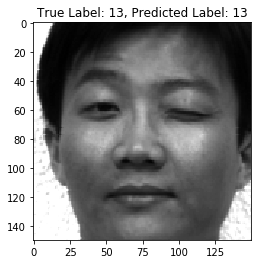

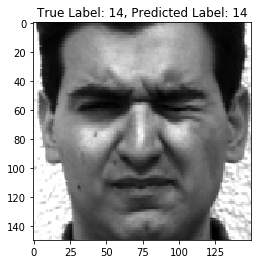

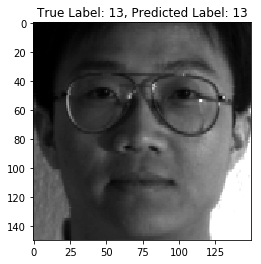

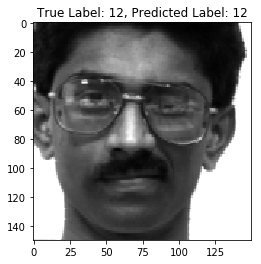

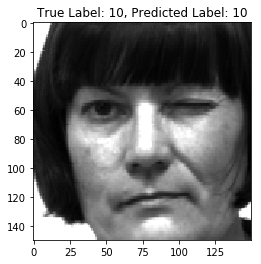

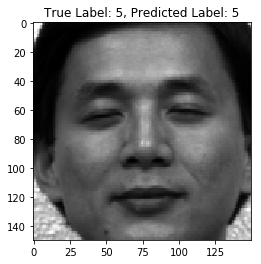

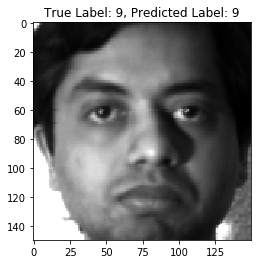

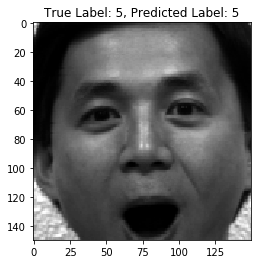

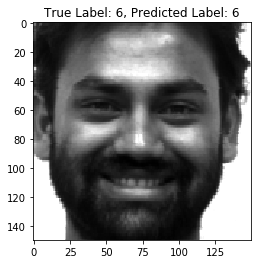

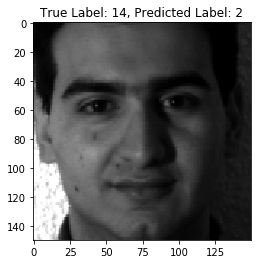

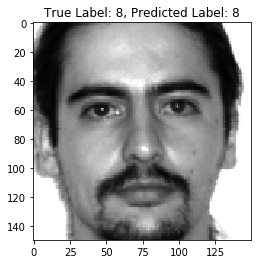

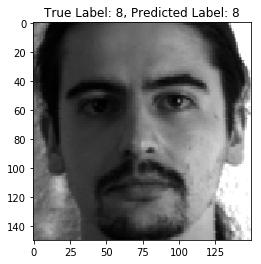

In [16]:
for i in range(len(Y_test)):
    img=X_test[i,:]
    X=img.reshape(1,22500)
    X=X.reshape(150,150)
    TrueLabel=np.argmax(Y_test[i,:], axis=0)
    plt.figure()
    plt.title("True Label: {}, Predicted Label: {}".format(TrueLabel,(PRlabel[i])[0]))
    plt.imshow(X, cmap='gray', interpolation='none')